In [1]:
# Jupyter Notebook: IMDb + Wikidata Location Visualizations
#
# Assumes you already ran the pipeline and produced:
#   data_out/movies_locations_long.parquet
# (from the modular pipeline we wrote)
#
# This notebook visualizes:
#   isAdult, startYear, runtimeMinutes, genres, averageRating
#   + filming locations on a global map

# ----------------------------
# Cell 1 — Imports & Settings
# ----------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: nicer progress bars
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

DATA_DIR = "data_out"
LONG_PATH = os.path.join(DATA_DIR, "movies_locations_long.parquet")

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (10, 5)


C:\Users\huynh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------
# Cell 2 — Load data
# ----------------------------
df = pd.read_parquet(LONG_PATH)

# Keep only filming locations that have coordinates
film = df[(df["location_kind"] == "filming")].copy()
film = film[film["lat"].notna() & film["lon"].notna()].copy()

print("Rows (all):", len(df))
print("Rows (filming w/ coords):", len(film))

df.head()


Rows (all): 764881
Rows (filming w/ coords): 30094


tconst titleType                   primaryTitle  \
0  tt0000009     movie                     Miss Jerry   
1  tt0000147     movie  The Corbett-Fitzsimmons Fight   
2  tt0000335     movie          Soldiers of the Cross   
3  tt0000502     movie                       Bohemios   
4  tt0000574     movie    The Story of the Kelly Gang   

                   originalTitle  isAdult  startYear  runtimeMinutes  \
0                     Miss Jerry        0     1894.0            45.0   
1  The Corbett-Fitzsimmons Fight        0     1897.0           100.0   
2          Soldiers of the Cross        0     1900.0            40.0   
3                       Bohemios        0     1905.0           100.0   
4    The Story of the Kelly Gang        0     1906.0            70.0   

                       genres  averageRating  numVotes            directors  \
0                     Romance            5.2     232.0            nm0085156   
1      Documentary,News,Sport            5.3     583.0            nm0714557   
2             Biography,Drama            5.5      65.0  nm0095714,nm0675140   
3                        None            3.1      26.0            nm0063413   
4  Action,Adventure,Biography            6.0    1046.0            nm0846879   

                         writers location_kind  \
0                      nm0085156          None   
1                           None      featured   
2                           None          None   
3  nm0063413,nm0657268,nm0675388          None   
4                      nm0846879       filming   

                          location_item location_label        lat         lon  \
0                                  None           None        NaN         NaN   
1  http://www.wikidata.org/entity/Q1227         Nevada  39.000000 -117.000000   
2                                  None           None        NaN         NaN   
3                                  None           None        NaN         NaN   
4  http://www.wikidata.org/entity/Q3141      Melbourne -37.814167  144.963056   

  location_class is_fictional  
0           None         None  
1           real        False  
2           None         None  
3           None         None  
4           real        False

In [3]:
# ----------------------------
# Cell 3 — Basic cleaning columns used for plots
# ----------------------------
# Ensure numeric types (parquet might preserve them, but safe)
for col in ["isAdult", "startYear", "runtimeMinutes", "averageRating", "numVotes"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Genres: split into list
def split_genres(x):
    if isinstance(x, str) and x.strip():
        return x.split(",")
    return []

df["genres_list"] = df["genres"].apply(split_genres)

# For map, choose one row per (movie, location_label, lat/lon) unique
film_unique = film.drop_duplicates(subset=["tconst", "location_label", "lat", "lon"]).copy()
film_unique.head()


tconst titleType                 primaryTitle  \
4    tt0000574     movie  The Story of the Kelly Gang   
75   tt0001530     movie       The Bushranger's Bride   
123  tt0002101     movie                    Cleopatra   
129  tt0002130     movie              Dante's Inferno   
130  tt0002130     movie              Dante's Inferno   

                       originalTitle  isAdult  startYear  runtimeMinutes  \
4        The Story of the Kelly Gang        0     1906.0            70.0   
75   Captain Midnight, the Bush King        0     1911.0             NaN   
123                        Cleopatra        0     1912.0           100.0   
129                        L'inferno        0     1911.0            71.0   
130                        L'inferno        0     1911.0            71.0   

                         genres  averageRating  numVotes  \
4    Action,Adventure,Biography            6.0    1046.0   
75                        Drama            5.9      24.0   
123               Drama,History            5.1     662.0   
129     Adventure,Drama,Fantasy            7.1    4011.0   
130     Adventure,Drama,Fantasy            7.1    4011.0   

                         directors              writers location_kind  \
4                        nm0846879            nm0846879       filming   
75                       nm0738202                 None       filming   
123                      nm0309130  nm0765026,nm0309130       filming   
129  nm0078205,nm0655824,nm0209738            nm0019604       filming   
130  nm0078205,nm0655824,nm0209738            nm0019604       filming   

                             location_item      location_label        lat  \
4     http://www.wikidata.org/entity/Q3141           Melbourne -37.814167   
75     http://www.wikidata.org/entity/Q408           Australia -25.000000   
123   http://www.wikidata.org/entity/Q1384            New York  43.000000   
129  http://www.wikidata.org/entity/Q16199   Province of Lecco  45.850000   
130  http://www.wikidata.org/entity/Q42935  Mandello del Lario  45.916667   

            lon location_class is_fictional  
4    144.963056           real        False  
75   133.000000           real        False  
123  -75.000000           real        False  
129    9.400000           real        False  
130    9.316667           real        False

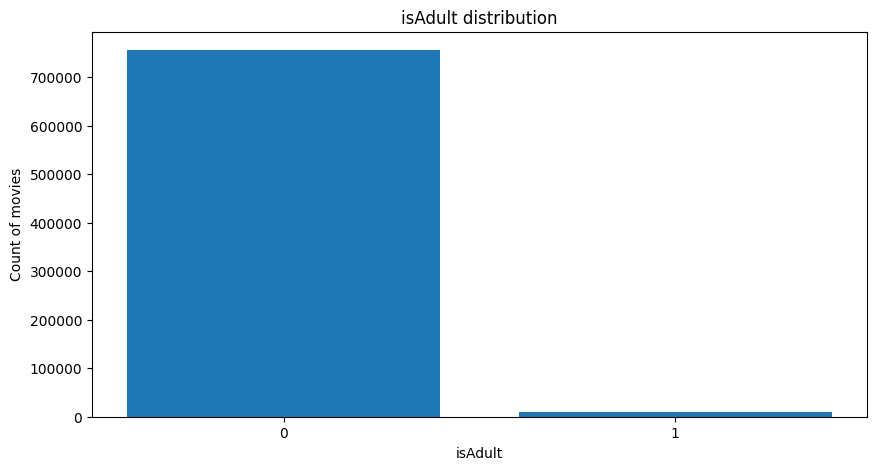

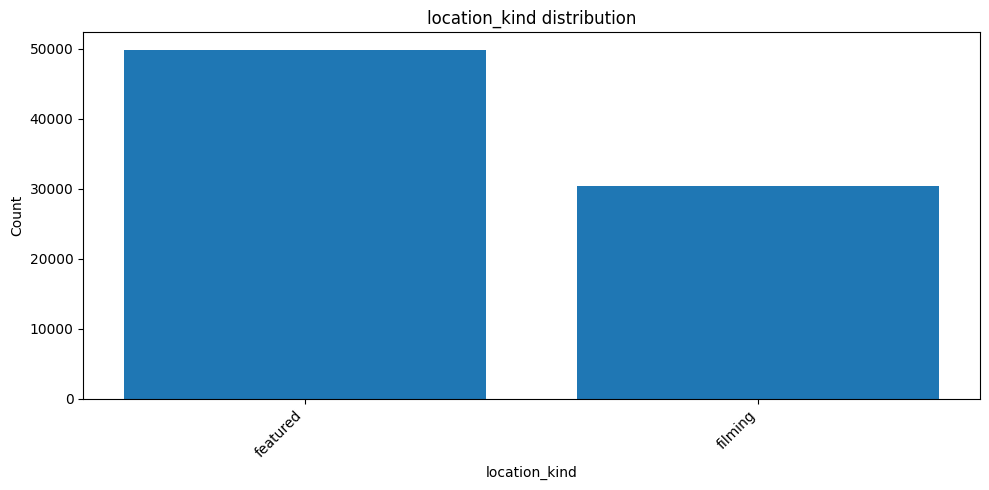

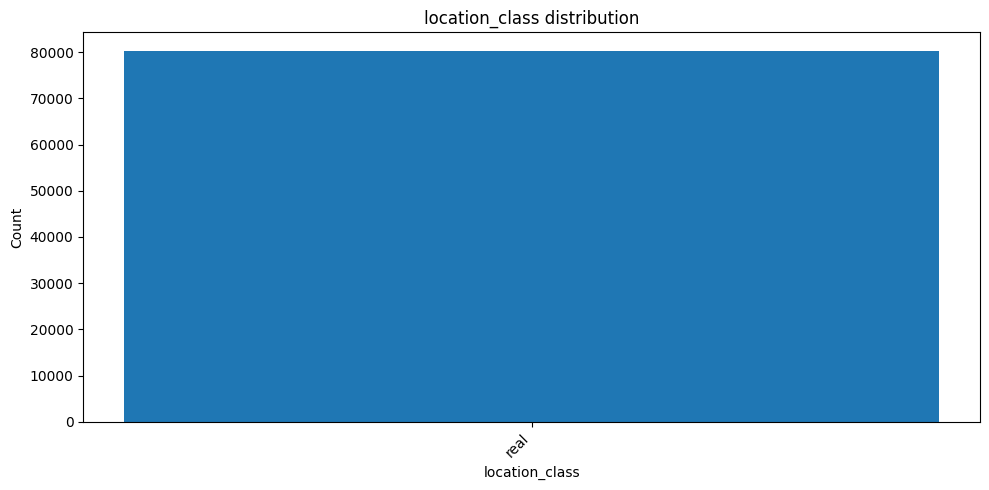

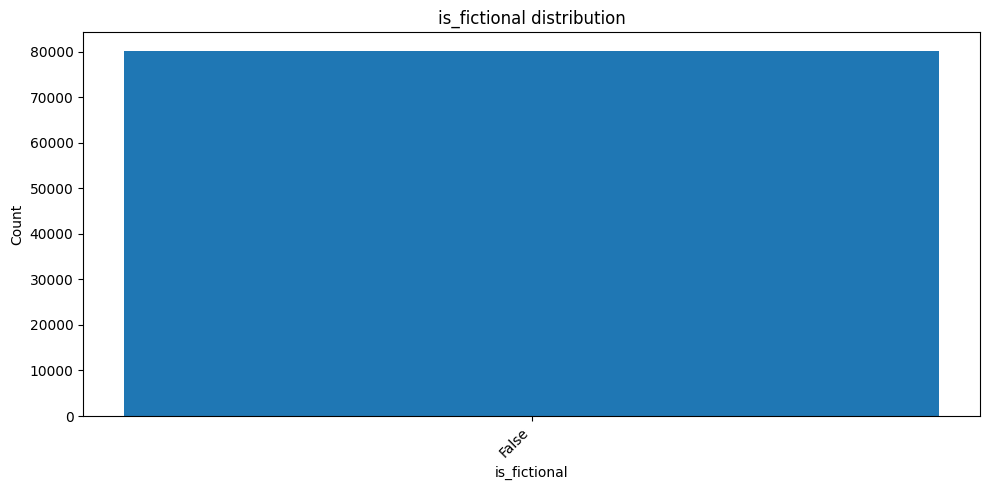

C:\Users\huynh\AppData\Local\Temp\ipykernel_19480\3636331916.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


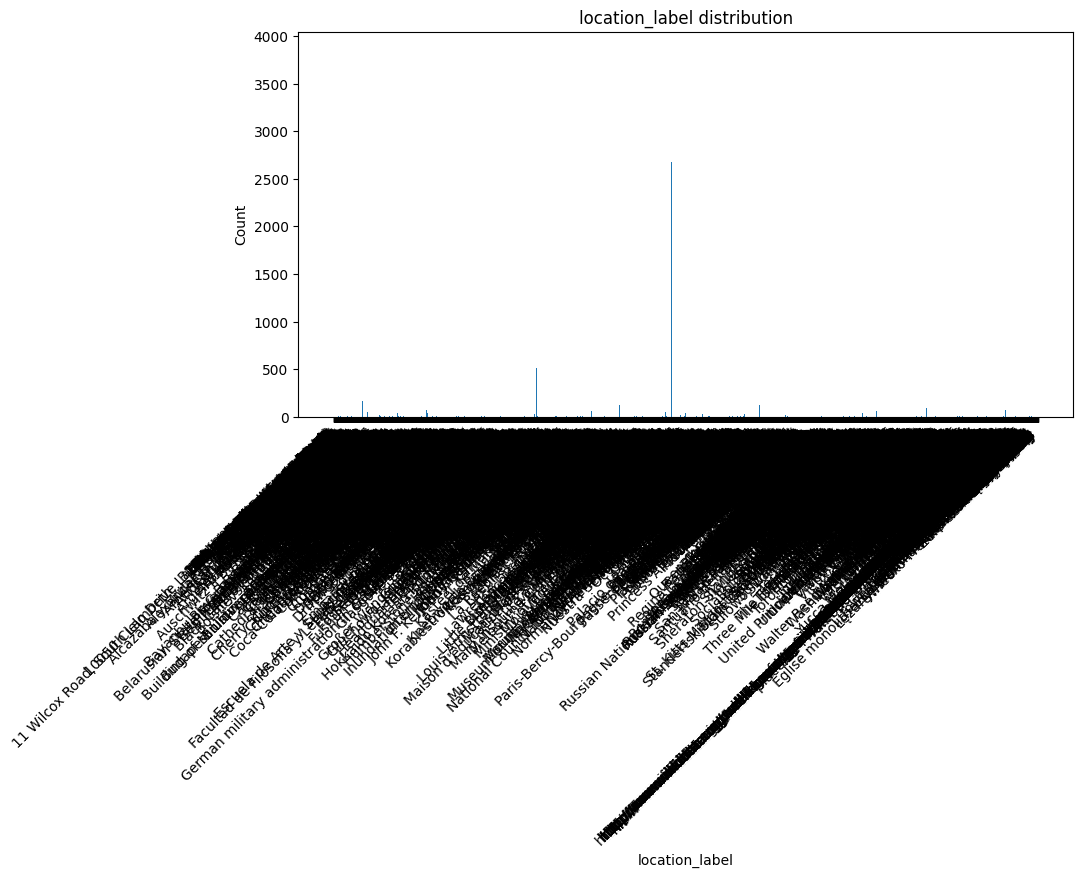

In [4]:
# ----------------------------
# Cell 4 — isAdult distribution
# ----------------------------
# isAdult: 0/1 typically
vals = df["isAdult"].dropna().astype(int)
counts = vals.value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("isAdult distribution")
plt.xlabel("isAdult")
plt.ylabel("Count of movies")
plt.show()
# ----------------------------
# Cell — categorical distributions
# ----------------------------
cols = ["location_kind", "location_class", "is_fictional","location_label"]

for col in cols:
    vals = df[col].dropna().astype(str).str.strip()
    counts = vals.value_counts().sort_index()

    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



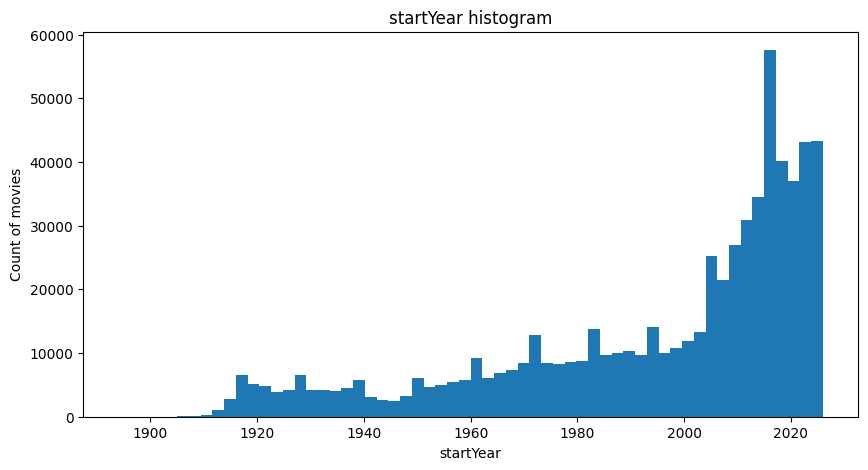

In [5]:
# ----------------------------
# Cell 5 — startYear histogram
# ----------------------------
years = df["startYear"].dropna()
# Focus on sane year range
years = years[(years >= 1880) & (years <= pd.Timestamp.now().year)]

plt.figure()
plt.hist(years, bins=60)
plt.title("startYear histogram")
plt.xlabel("startYear")
plt.ylabel("Count of movies")
plt.show()


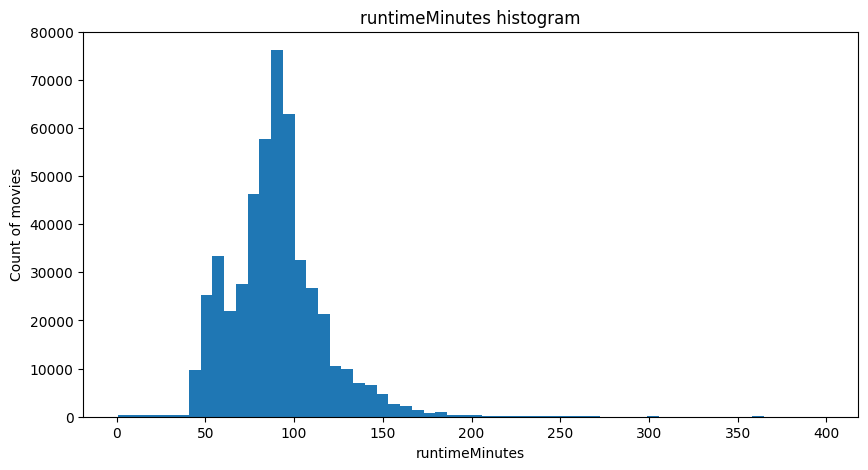

In [6]:
# ----------------------------
# Cell 6 — runtimeMinutes histogram
# ----------------------------
rt = df["runtimeMinutes"].dropna()
# Filter out extreme outliers
rt = rt[(rt > 0) & (rt < 400)]

plt.figure()
plt.hist(rt, bins=60)
plt.title("runtimeMinutes histogram")
plt.xlabel("runtimeMinutes")
plt.ylabel("Count of movies")
plt.show()


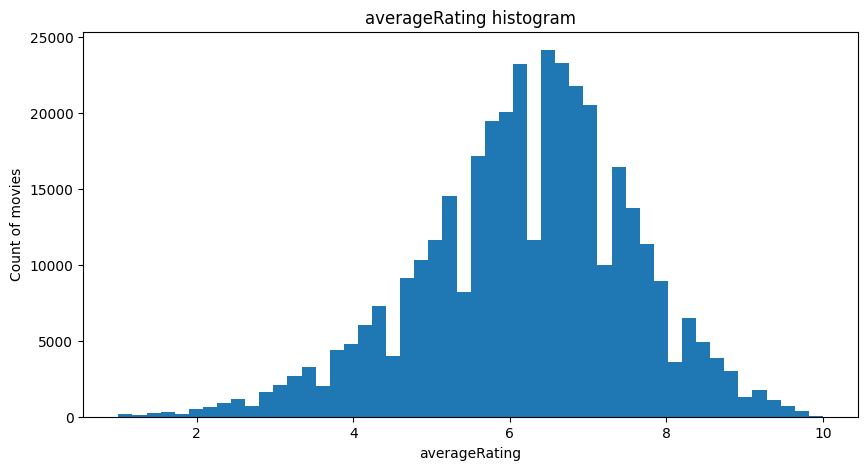

In [7]:
# ----------------------------
# Cell 7 — averageRating histogram
# ----------------------------
rat = df["averageRating"].dropna()
rat = rat[(rat >= 0) & (rat <= 10)]

plt.figure()
plt.hist(rat, bins=50)
plt.title("averageRating histogram")
plt.xlabel("averageRating")
plt.ylabel("Count of movies")
plt.show()


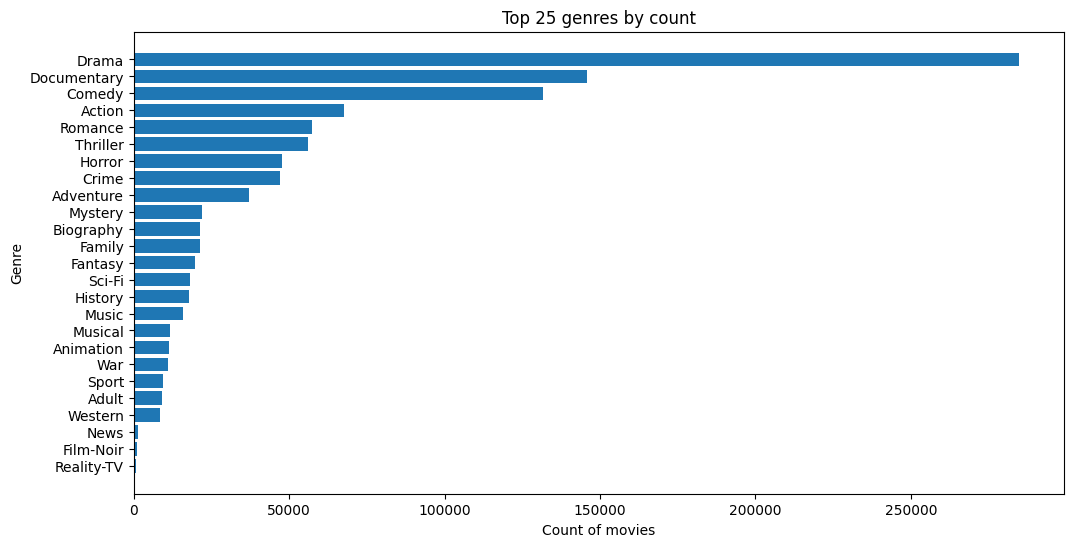

In [8]:
# ----------------------------
# Cell 8 — Genres frequency (top 25)
# ----------------------------
from collections import Counter

genre_counts = Counter()
for gl in df["genres_list"]:
    genre_counts.update(gl)

top = genre_counts.most_common(25)
labels = [g for g, c in top]
values = [c for g, c in top]

plt.figure(figsize=(12, 6))
plt.barh(labels[::-1], values[::-1])
plt.title("Top 25 genres by count")
plt.xlabel("Count of movies")
plt.ylabel("Genre")
plt.show()


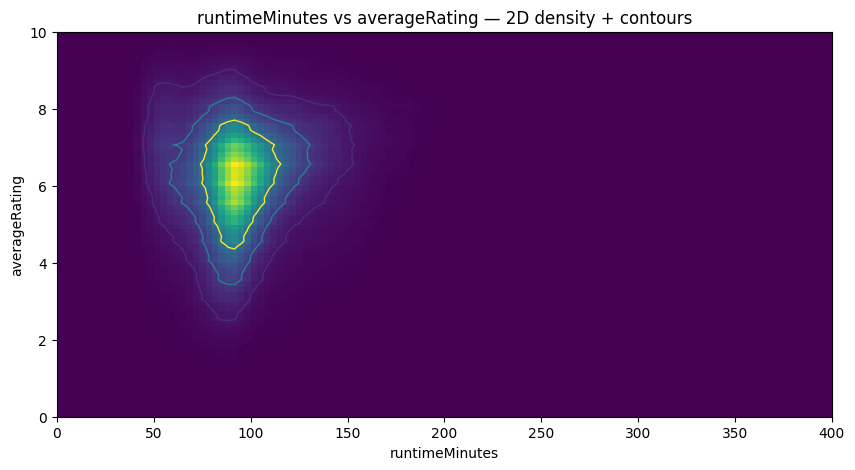

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# runtime vs rating
tmp = df[["runtimeMinutes", "averageRating", "numVotes"]].dropna().copy()
tmp = tmp[(tmp["runtimeMinutes"] > 0) & (tmp["runtimeMinutes"] < 400)]
tmp = tmp[(tmp["averageRating"] >= 0) & (tmp["averageRating"] <= 10)]

x = tmp["runtimeMinutes"].to_numpy()
y = tmp["averageRating"].to_numpy()

# 2D histogram density
bins_x, bins_y = 120, 80
H, xedges, yedges = np.histogram2d(x, y, bins=[bins_x, bins_y], range=[[0, 400], [0, 10]])

# Smooth a little (lightweight blur without scipy)
# Simple separable blur kernel
kernel = np.array([1, 2, 3, 2, 1], dtype=float)
kernel /= kernel.sum()

def blur2d(A, k):
    # blur rows
    B = np.apply_along_axis(lambda r: np.convolve(r, k, mode="same"), 1, A)
    # blur cols
    C = np.apply_along_axis(lambda c: np.convolve(c, k, mode="same"), 0, B)
    return C

Hs = blur2d(H, kernel)

# Build centers for contouring
xc = (xedges[:-1] + xedges[1:]) / 2
yc = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(xc, yc, indexing="xy")  # careful: histogram2d outputs shape (bins_x, bins_y) but we transpose below

plt.figure(figsize=(10, 5))

# imshow expects [y, x], so transpose
plt.imshow(
    Hs.T,
    origin="lower",
    aspect="auto",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
)

# Contour “topological” levels (quantiles of density)
positive = Hs[Hs > 0]
if len(positive):
    levels = np.quantile(positive, [0.70, 0.85, 0.93, 0.97])
    plt.contour(
        xc, yc, Hs.T,
        levels=levels,
        linewidths=1.0
    )

plt.title("runtimeMinutes vs averageRating — 2D density + contours")
plt.xlabel("runtimeMinutes")
plt.ylabel("averageRating")
plt.xlim(0, 400)
plt.ylim(0, 10)
plt.show()


In [10]:
# ----------------------------
# Cell 10 — Global map of filming locations (Plotly if available)
# ----------------------------
# We'll plot filming coords on a world map.
# Point size can scale with numVotes, and color with averageRating.

# Build a per-location row that also carries movie metadata.
# For a map, you usually want fewer points; sample if huge.
map_df = film_unique[["tconst", "primaryTitle", "startYear", "averageRating", "numVotes", "location_label", "lat", "lon"]].copy()
map_df["averageRating"] = pd.to_numeric(map_df["averageRating"], errors="coerce")
map_df["numVotes"] = pd.to_numeric(map_df["numVotes"], errors="coerce")

# Optional: downsample if too many points (keeps notebook responsive)
MAX_POINTS = 200000
if len(map_df) > MAX_POINTS:
    map_df = map_df.sample(MAX_POINTS, random_state=0)

map_df.head()


tconst                 primaryTitle  startYear  averageRating  \
4    tt0000574  The Story of the Kelly Gang     1906.0            6.0   
75   tt0001530       The Bushranger's Bride     1911.0            5.9   
123  tt0002101                    Cleopatra     1912.0            5.1   
129  tt0002130              Dante's Inferno     1911.0            7.1   
130  tt0002130              Dante's Inferno     1911.0            7.1   

     numVotes      location_label        lat         lon  
4      1046.0           Melbourne -37.814167  144.963056  
75       24.0           Australia -25.000000  133.000000  
123     662.0            New York  43.000000  -75.000000  
129    4011.0   Province of Lecco  45.850000    9.400000  
130    4011.0  Mandello del Lario  45.916667    9.316667

In [11]:
# Try Plotly first (interactive globe/map)
try:
    import plotly.express as px

    # Build a size column; log scale votes for sanity
    map_df["size"] = np.log10(map_df["numVotes"].fillna(1) + 1)

    fig = px.scatter_geo(
        map_df,
        lat="lat",
        lon="lon",
        hover_name="primaryTitle",
        hover_data={"location_label": True, "startYear": True, "averageRating": True, "numVotes": True, "lat": False, "lon": False},
        size="size",
        color="averageRating",
        projection="natural earth",
        title="Filming locations (points sized by log10(votes+1), colored by averageRating)"
    )
    fig.show()

except Exception as e:
    print("Plotly not available or failed:", e)
    print("Falling back to a static matplotlib scatter (no basemap).")

    # Static fallback: lon/lat scatter
    plt.figure(figsize=(14, 6))
    plt.scatter(map_df["lon"], map_df["lat"], s=1)
    plt.title("Filming locations (lon/lat scatter)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


In [52]:
import pandas as pd
import numpy as np

# df is your merged long dataframe
film = df[(df["location_kind"] == "featured")].copy()
film = film[film["lat"].notna() & film["lon"].notna()].copy()

# Ensure genres_list exists (from earlier cell); if not, create it
if "genres_list" not in film.columns:
    film["genres_list"] = film["genres"].fillna("").apply(lambda s: s.split(",") if s else [])

# Keep only what we need
# film = film[["tconst", "primaryTitle", "genres_list", "lat", "lon", "location_label"]].copy()

# optional: drop exact duplicate points for same movie
film = film.drop_duplicates(subset=["tconst", "lat", "lon"])

film.head()
print("Total filming location points:", len(df))


Total filming location points: 764881


In [53]:
grid_deg = 1  # <-- tune this: 0.1 tighter, 0.25 typical, 0.5 coarse

# quantize into bins
film["lat_bin"] = (film["lat"] / grid_deg).round().astype(int)
film["lon_bin"] = (film["lon"] / grid_deg).round().astype(int)

# bin center coords (for mapping)
film["lat_c"] = film["lat_bin"] * grid_deg
film["lon_c"] = film["lon_bin"] * grid_deg

# a stable group id
film["city_id"] = film["lat_bin"].astype(str) + "_" + film["lon_bin"].astype(str)

film[["city_id", "lat_c", "lon_c"]].head()


city_id  lat_c  lon_c
1    39_-117     39   -117
69     56_10     56     10
112    53_-1     53     -1
144    42_12     42     12
153  23_-102     23   -102

In [54]:
from collections import Counter
import math

# Use unique movies for IDF baseline (not long rows)
N = df["tconst"].nunique()

# Global document frequency: count each genre at most once per movie
df_global = Counter()
for gl in df.drop_duplicates("tconst")["genres_list"]:
    if isinstance(gl, list):
        df_global.update(set(gl))

def tfidf_score(genre, local_count, local_total):
    tf = local_count / max(1, local_total)
    idf = math.log(N / max(1, df_global.get(genre, 1)))
    return tf * idf

def top_genre_tfidf(genres_lists_series):
    """
    Count per-movie presence using set(gl).
    Assumes input already has <=1 row per movie per grid.
    """
    c = Counter()
    for gl in genres_lists_series:
        if isinstance(gl, list) and gl:
            c.update(set(gl))

    total = sum(c.values())
    if total == 0:
        return None

    best_g, best_s = None, -1.0
    for g, cnt in c.items():
        s = tfidf_score(g, cnt, total)
        if s > best_s:
            best_g, best_s = g, s
    return best_g

def most_common_label(series, k: int = 3) -> str | None:
    """
    Return a single string with the top-K most common labels, separated by ' | '.
    """
    s = series.dropna().astype(str).str.strip()
    s = s[s != ""]
    if len(s) == 0:
        return None

    topk = s.value_counts().head(k).index.tolist()
    return " | ".join(topk)

# ---- NEW: collapse to one row per (city_id, tconst) ----
film_one_per_movie_in_city = (
    film.groupby(["city_id", "tconst"], as_index=False)
        .agg(
            lat_c=("lat_c", "mean"),
            lon_c=("lon_c", "mean"),
            genres_list=("genres_list", "first"),          # same per tconst usually; adjust if needed
            location_label=("location_label", most_common_label),
        )
)

# ---- City aggregation now cannot double-count movies within a grid ----
city = (
    film_one_per_movie_in_city.groupby("city_id")
    .agg(
        lat=("lat_c", "mean"),
        lon=("lon_c", "mean"),
        n_movies=("tconst", "nunique"),
        top_genre=("genres_list", top_genre_tfidf),
        label_guess=("location_label", most_common_label),
    )
    .reset_index()
)

city = city[city["n_movies"] >= 5].copy()
city.sort_values("n_movies", ascending=False).head(20)


city_id   lat    lon  n_movies top_genre  \
782    41_-74  41.0  -74.0      2841    Comedy   
1191     52_0  52.0    0.0      2272     Crime   
1105     49_2  49.0    2.0      1964    Comedy   
87     -2_118  -2.0  118.0      1790     Drama   
834     42_12  42.0   12.0      1765    Comedy   
507   34_-118  34.0 -118.0      1506     Crime   
1213    53_-1  53.0   -1.0      1434     Drama   
607   37_-120  37.0 -120.0       844    Comedy   
1039     47_2  47.0    2.0       789     Drama   
311    22_114  22.0  114.0       748    Action   
732     40_-4  40.0   -4.0       728    Comedy   
1225    53_13  53.0   13.0       528     Drama   
796     41_14  41.0   14.0       479    Comedy   
642   38_-122  38.0 -122.0       479     Crime   
592    36_140  36.0  140.0       460    Action   
556    35_136  35.0  136.0       459     Drama   
1323    59_18  59.0   18.0       445    Comedy   
318   23_-102  23.0 -102.0       422   Western   
696    39_-77  39.0  -77.0       414    Action   
806     41_29  41.0   29.0       409    Comedy   

                                            label_guess  
782                New York City | Brooklyn | Manhattan  
1191            London | British Empire | Hertfordshire  
1105          Paris | Île-de-France | Seine-Saint-Denis  
87                                            Indonesia  
834                         Rome | Italy | Ancient Rome  
507          Los Angeles | Beverly Hills | Santa Monica  
1213                   England | Nottingham | Sheffield  
607                                 California | Clovis  
1039                                    France | Creuse  
311               Hong Kong | Macau | Hong Kong | Macau  
732                             Spain | Madrid | Toledo  
1225                Berlin | East Berlin | German Reich  
796                           Naples | Capri | Sorrento  
642   San Francisco | San Francisco Bay Area | San Q...  
592                               Tokyo | Edo | Shibuya  
556                    Japan | Kyoto | Kyoto Prefecture  
1323  Stockholm | Stockholm | Royal Swedish Opera | ...  
318                                              Mexico  
696             Washington, D.C. | Baltimore | Maryland  
806        Istanbul | Ottoman Empire | Byzantine Empire

In [55]:
import plotly.express as px
import numpy as np

# size scaling so large cities don't dominate
city["marker_size"] = np.sqrt(city["n_movies"])

fig = px.scatter_geo(
    city,
    lat="lat",
    lon="lon",
    size="marker_size",
    color="top_genre",
    hover_name="label_guess",
    hover_data={
        "n_movies": True,
        "top_genre": True,
        "lat": ":.3f",
        "lon": ":.3f",
        "marker_size": False,
        "city_id": True,
    },
    projection="natural earth",
    title=f"Filming location city-groups (grid={grid_deg}°): size=#movies, color=top genre"
)

fig.show()


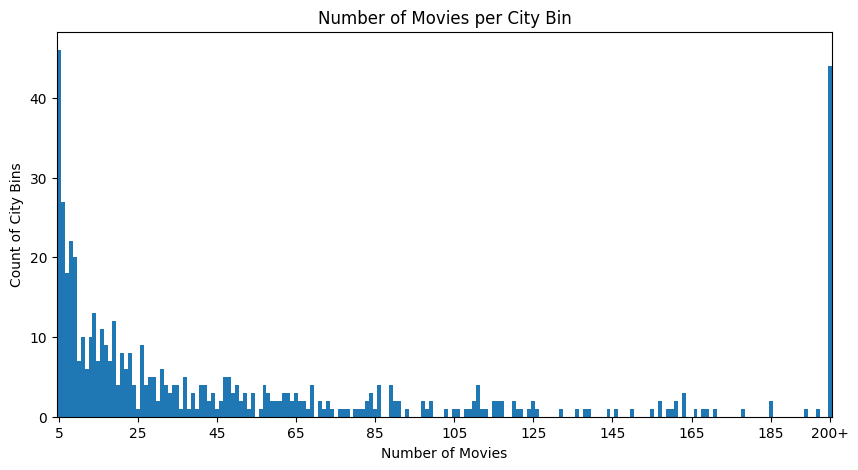

In [56]:
# Histogram with capped upper bin
MAX = 200

vals = city["n_movies"].dropna().astype(int)
# Clip values above MAX into the final bin at MAX
clipped = vals.copy()
clipped[clipped > MAX] = MAX

import numpy as np

start = int(max(0, clipped.min()))
x = np.arange(start, MAX + 1)
counts = clipped.value_counts().reindex(x, fill_value=0).sort_index()
y = counts.values

plt.figure()
plt.bar(x, y, width=1.0, align="center")
plt.title("Number of Movies per City Bin")
plt.xlabel("Number of Movies")
plt.ylabel("Count of City Bins")
plt.xlim(start - 0.5, MAX + 0.5)

# xticks every 5 units, ensure final tick shows as '200+'
xticks = np.arange(start, MAX + 1, 20)
if xticks[-1] != MAX:
    xticks = np.append(xticks, MAX)
xticklabels = [str(int(t)) for t in xticks]
for i, t in enumerate(xticks):
    if int(t) == MAX:
        xticklabels[i] = f"{MAX}+"
        break
plt.xticks(xticks, xticklabels)
plt.show()

In [57]:
# Given a city_id from your aggregated `city` table,
# return the list of unique movies filmed in that city bin,
# with useful columns (title, year, rating, votes, runtime, genres, label)

import pandas as pd

TARGET_CITY_ID = "10_76"   # <-- change this

# `film` should be the filming-only dataframe you used to build `city`
# (must include: city_id, tconst, primaryTitle, startYear, averageRating, numVotes, runtimeMinutes, genres, location_label)
# If `film` doesn't have these columns, merge them in from `df` before running.

cols_wanted = [
    "tconst",
    "primaryTitle",
    "startYear",
    "averageRating",
    "numVotes",
    "runtimeMinutes",
    "genres",
    "location_label",
    "lat", "lon",
    "lat_c", "lon_c",
    "city_id",
]

# Keep only columns that exist (avoid KeyErrors)
cols_present = [c for c in cols_wanted if c in film.columns]

movies_in_city = film[film["city_id"] == TARGET_CITY_ID][cols_present].copy()
# Deduplicate to unique movies (keep the first row per tconst)
# If a movie appears multiple times with different location labels/points in the same bin,
# this keeps one representative row per movie.
movies_unique = (
    movies_in_city
    .sort_values(["tconst"])
    .drop_duplicates(subset=["tconst"], keep="first")
    .sort_values(["averageRating", "numVotes"], ascending=[False, False], na_position="last")
    .reset_index(drop=True)
)

print("City:", TARGET_CITY_ID)
if "lat_c" in movies_unique.columns and "lon_c" in movies_unique.columns:
    print("Bin center (lat_c, lon_c):", movies_unique["lat_c"].iloc[0], movies_unique["lon_c"].iloc[0])
print("Unique movies:", len(movies_unique))

movies_unique.head(25)

# Optional: export the full list to CSV
out_path = f"movies_city_{TARGET_CITY_ID}.csv".replace("/", "_")
movies_unique.to_csv(out_path, index=False)
print("Wrote:", out_path)

# Optional: if you want ALL filming points/labels (not deduped by tconst)
movies_in_city.sort_values(["tconst"]).head(50)

City: 10_76
Bin center (lat_c, lon_c): 10 76
Unique movies: 61
Wrote: movies_city_10_76.csv


tconst                                       primaryTitle  \
62288    tt0079422                                           Kummatty   
89823    tt0116749                                   Man of the Story   
109406   tt0155734                                 Guruvayoor Kesavan   
109407   tt0155735                              Guruvayoor Mahathmiam   
132254   tt0200838                                  Marana Simhasanam   
138720   tt0214478                            Anubhavangal Palichakal   
155627   tt0254591                                          Muthalali   
156019   tt0255289                                          Kaalapani   
157273   tt0257832                                     Kannoor Deluxe   
164541   tt0273096                                        Asuravamsam   
164904   tt0274043                          Rektha Sakshikal Zindabad   
193363   tt0353519                                      Grihaprevesam   
222664   tt0463429                              Bharathchandran I.P.S   
237608   tt0881930                                           Kayyoppu   
256842  tt10551608                            Thanneermathan Dinangal   
260878   tt1073653                                            Alibhai   
280684  tt11591490                                      A Night A Day   
299288   tt1245741                                         Thalappavu   
339625   tt1430074                                   The Mother Earth   
340646   tt1433543                                          Passenger   
374930   tt1602585                                   Ye Maaya Chesave   
378437   tt1628768                                   The Bird Catcher   
382129   tt1656171                                             Dam999   
390879   tt1745863  Urumi: The Warriors Who Wanted to Kill Vasco D...   
401076   tt1841762                                              Mynaa   
414298   tt1988774                                     Salt n' Pepper   
429060   tt2126282                                    Ekk Deewana Tha   
437300   tt2188733                                  Ee Adutha Kaalath   
439420   tt2200830                                7 Notes to Infinity   
452066   tt2325845                                     Malabar Police   
454500   tt2355771                                     Papilio Buddha   
461246   tt2418248                                   Ivan Megharoopan   
466189   tt2522328                                            Shutter   
468939   tt2578334                                  Molly Aunty Rocks   
471500   tt2631098                                     Nee Ko Nja Cha   
477313   tt2679530                       Natholi Oru Cheriya Meenalla   
514809   tt3005850                                    Sooper Se Ooper   
527182   tt3124456                                           Memories   
532440   tt3175286                                   Ezhamathe Varavu   
534932   tt3198468                                   North 24 Kaatham   
548396   tt3288508                                       Arikil Oraal   
560881   tt3385854                                             Artist   
563021   tt3417422                                           Drishyam   
612590   tt3845746                                   Njan Steve Lopez   
646084   tt4664092                            Oru Second Class Yathra   
650179   tt4818930                                            Waiting   
651102   tt4851630                            Maheshinte Prathikaaram   
652484   tt4903366                                   Idhu Enna Maayam   
659533   tt5147626                              Chaayam Poosiya Veedu   
663963   tt5297256                                        Pulimurugan   

        startYear  averageRating  numVotes  runtimeMinutes  \
62288      1979.0            7.3     458.0            90.0   
89823      1995.0            7.1     153.0           107.0   
109406     1977.0            6.9      32.0           118.0   
109407     1984.0            NaN       N